In [1]:
import PIL
import time
import torch
import torchvision
import torch.nn.functional as F
from einops import rearrange
from torch import nn
import torch.nn.init as init
from ViTResNet import *
from common import check_on_dataset
from common import create_graph_comparison

In [2]:
BATCH_SIZE_TRAIN = 200
BATCH_SIZE_TEST = 200
EPOCHS = 150
device = torch.device('cuda')

DL_PATH = "./data" # Use your own path
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
transform_train = torchvision.transforms.Compose(
     [torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
     torchvision.transforms.RandomAffine(8, translate=(.15,.15)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

transform_test = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_dataset = torchvision.datasets.CIFAR10(DL_PATH, train=True,
                                        download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(DL_PATH, train=False,
                                        download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST,
                                         shuffle=False)

C:\Users\dmele\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\transforms.py:1200: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(
Files already downloaded and verified
Files already downloaded and verified


In [3]:
model = ViTResNet(BasicBlock, [3, 3, 3], BATCH_SIZE_TRAIN).to(device)
check_on_dataset(model, train_loader, test_loader, EPOCHS, "cifar10", "ViTResNet")

cy: 88.9420

Average test loss: 0.4400

Test accuracy: 86.1000
Epoch: 72
[    0/50000 (  0%)]  Loss: 0.3664
[20000/50000 ( 40%)]  Loss: 0.3581
[40000/50000 ( 80%)]  Loss: 0.2685
Execution time: 19.83 seconds

Average train loss: 0.3436

Train accuracy: 88.4040

Average test loss: 0.4876

Test accuracy: 84.9200
Epoch: 73
[    0/50000 (  0%)]  Loss: 0.3084
[20000/50000 ( 40%)]  Loss: 0.1938
[40000/50000 ( 80%)]  Loss: 0.2499
Execution time: 19.81 seconds

Average train loss: 0.3150

Train accuracy: 89.4740

Average test loss: 0.4327

Test accuracy: 86.5600
Epoch: 74
[    0/50000 (  0%)]  Loss: 0.3755
[20000/50000 ( 40%)]  Loss: 0.2503
[40000/50000 ( 80%)]  Loss: 0.3649
Execution time: 19.79 seconds

Average train loss: 0.3204

Train accuracy: 89.1540

Average test loss: 0.4069

Test accuracy: 86.7700
Epoch: 75
[    0/50000 (  0%)]  Loss: 0.2443
[20000/50000 ( 40%)]  Loss: 0.3909
[40000/50000 ( 80%)]  Loss: 0.4354
Execution time: 19.79 seconds

Average train loss: 0.3377

Train accuracy: 

In [3]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=False).to(device)
check_on_dataset(model, train_loader, test_loader, EPOCHS, "cifar10", "ResNet18")

cy: 91.1040

Average test loss: 0.5667

Test accuracy: 83.5100
Epoch: 72
[    0/50000 (  0%)]  Loss: 0.2139
[20000/50000 ( 40%)]  Loss: 0.3062
[40000/50000 ( 80%)]  Loss: 0.3266
Execution time: 23.74 seconds

Average train loss: 0.2552

Train accuracy: 90.9040

Average test loss: 0.5732

Test accuracy: 83.8800
Epoch: 73
[    0/50000 (  0%)]  Loss: 0.3270
[20000/50000 ( 40%)]  Loss: 0.3223
[40000/50000 ( 80%)]  Loss: 0.2347
Execution time: 23.74 seconds

Average train loss: 0.2605

Train accuracy: 90.6800

Average test loss: 0.5858

Test accuracy: 83.6900
Epoch: 74
[    0/50000 (  0%)]  Loss: 0.3272
[20000/50000 ( 40%)]  Loss: 0.2937
[40000/50000 ( 80%)]  Loss: 0.3559
Execution time: 23.75 seconds

Average train loss: 0.2522

Train accuracy: 90.9440

Average test loss: 0.5899

Test accuracy: 83.4100
Epoch: 75
[    0/50000 (  0%)]  Loss: 0.2949
[20000/50000 ( 40%)]  Loss: 0.3120
[40000/50000 ( 80%)]  Loss: 0.2438
Execution time: 23.75 seconds

Average train loss: 0.2525

Train accuracy: 

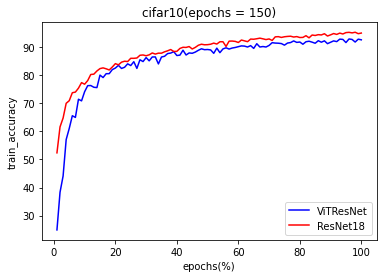

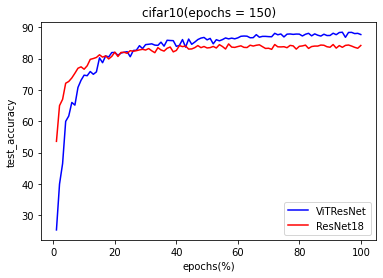

In [4]:

create_graph_comparison("cifar10", "ViTResNet", "ResNet18")

In [3]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=False).to(device)
check_on_dataset(model, train_loader, test_loader, EPOCHS, "cifar10", "ResNet34")

cy: 90.4040

Average test loss: 0.5538

Test accuracy: 83.5100
Epoch: 72
[    0/50000 (  0%)]  Loss: 0.2008
[20000/50000 ( 40%)]  Loss: 0.3029
[40000/50000 ( 80%)]  Loss: 0.3181
Execution time: 40.95 seconds

Average train loss: 0.2738

Train accuracy: 90.2400

Average test loss: 0.5125

Test accuracy: 84.6900
Epoch: 73
[    0/50000 (  0%)]  Loss: 0.2447
[20000/50000 ( 40%)]  Loss: 0.3057
[40000/50000 ( 80%)]  Loss: 0.3153
Execution time: 40.94 seconds

Average train loss: 0.2659

Train accuracy: 90.5160

Average test loss: 0.5404

Test accuracy: 83.8700
Epoch: 74
[    0/50000 (  0%)]  Loss: 0.1617
[20000/50000 ( 40%)]  Loss: 0.2499
[40000/50000 ( 80%)]  Loss: 0.4017
Execution time: 40.94 seconds

Average train loss: 0.2531

Train accuracy: 91.1500

Average test loss: 0.5352

Test accuracy: 84.5400
Epoch: 75
[    0/50000 (  0%)]  Loss: 0.2730
[20000/50000 ( 40%)]  Loss: 0.3302
[40000/50000 ( 80%)]  Loss: 0.2738
Execution time: 40.96 seconds

Average train loss: 0.2891

Train accuracy: 

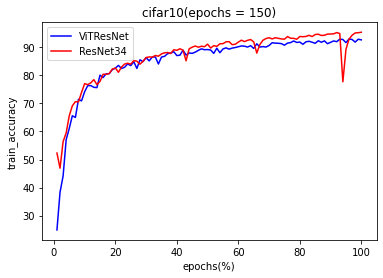

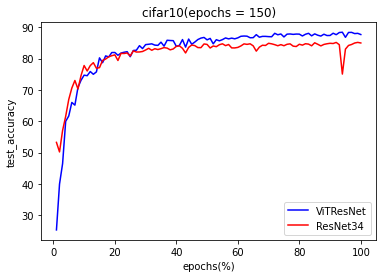

In [4]:
create_graph_comparison("cifar10", "ViTResNet", "ResNet34")

In [3]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=False).to(device)
check_on_dataset(model, train_loader, test_loader, EPOCHS, "cifar10", "ResNet50")

/50000 (  0%)]  Loss: 0.3874
[20000/50000 ( 40%)]  Loss: 0.4115
[40000/50000 ( 80%)]  Loss: 0.4068
Execution time: 107.24 seconds

Average train loss: 0.3652

Train accuracy: 87.9060

Average test loss: 0.7709

Test accuracy: 83.0200
Epoch: 73
[    0/50000 (  0%)]  Loss: 0.3467
[20000/50000 ( 40%)]  Loss: 0.2854
[40000/50000 ( 80%)]  Loss: 0.3985
Execution time: 107.29 seconds

Average train loss: 0.3266

Train accuracy: 88.6720

Average test loss: 0.5889

Test accuracy: 83.6200
Epoch: 74
[    0/50000 (  0%)]  Loss: 0.3860
[20000/50000 ( 40%)]  Loss: 0.2609
[40000/50000 ( 80%)]  Loss: 0.4074
Execution time: 107.28 seconds

Average train loss: 0.3046

Train accuracy: 89.3400

Average test loss: 0.5224

Test accuracy: 84.1400
Epoch: 75
[    0/50000 (  0%)]  Loss: 0.2477
[20000/50000 ( 40%)]  Loss: 0.2502
[40000/50000 ( 80%)]  Loss: 0.3603
Execution time: 107.25 seconds

Average train loss: 0.3160

Train accuracy: 89.5940

Average test loss: 0.6604

Test accuracy: 84.1300
Epoch: 76
[    0

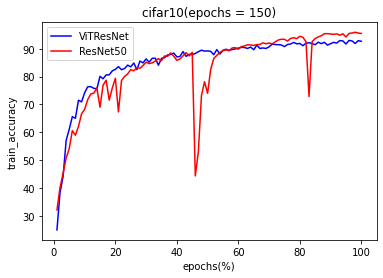

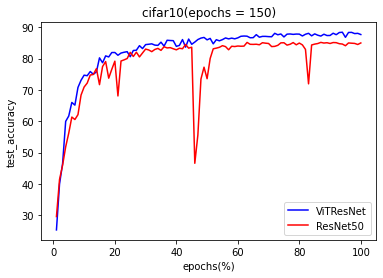

In [4]:
create_graph_comparison("cifar10", "ViTResNet", "ResNet50")

In [5]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet101', pretrained=False).to(device)
check_on_dataset(model, train_loader, test_loader, EPOCHS, "cifar10", "ResNet101")

Using cache found in C:\Users\dmele/.cache\torch\hub\pytorch_vision_v0.9.0
Epoch: 1
[    0/50000 (  0%)]  Loss: 7.3219
[20000/50000 ( 40%)]  Loss: 2.2300
[40000/50000 ( 80%)]  Loss: 2.1575
Execution time: 201.91 seconds

Average train loss: 2.4399

Train accuracy: 12.8460

Average test loss: 2.4143

Test accuracy: 14.1400
Epoch: 2
[    0/50000 (  0%)]  Loss: 2.0232
[20000/50000 ( 40%)]  Loss: 2.1017
[40000/50000 ( 80%)]  Loss: 2.3317
Execution time: 202.44 seconds

Average train loss: 2.0841

Train accuracy: 21.6020

Average test loss: 2.0579

Test accuracy: 23.0900
Epoch: 3
[    0/50000 (  0%)]  Loss: 2.0447
[20000/50000 ( 40%)]  Loss: 1.9793
[40000/50000 ( 80%)]  Loss: 1.9061
Execution time: 201.14 seconds

Average train loss: 2.4513

Train accuracy: 17.2780

Average test loss: 2.3122

Test accuracy: 18.7800
Epoch: 4
[    0/50000 (  0%)]  Loss: 2.0498
[20000/50000 ( 40%)]  Loss: 1.8206
[40000/50000 ( 80%)]  Loss: 1.8884
Execution time: 202.08 seconds

Average train loss: 2.2309

Trai

KeyboardInterrupt: 

In [ ]:
create_graph_comparison("cifar10", "ViTResNet", "ResNet101")